In [19]:
from matplotlib.pyplot import *
import numpy as np

In [20]:
m1 = 1
m2 = 3
m3 = 2
b = 0.001

x0 = 0
dx0 = 0

e0 = 0
de0 = 3

a = np.pi / 6
g = 10


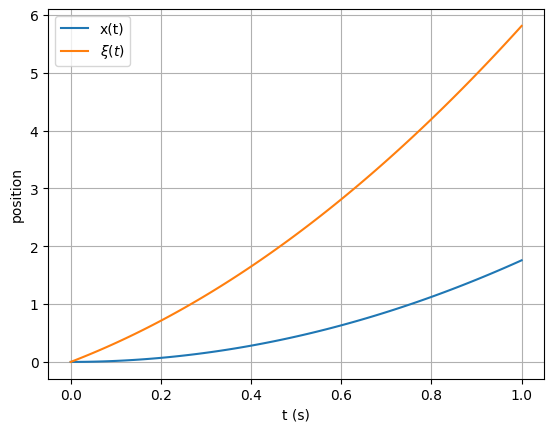

In [21]:
from scipy.integrate import odeint


def f(u, x):
    masses = np.array(
        [
            [m1 + m2 + 3 * m3, m1 * np.cos(a)],
            [m1 * np.cos(a), m1],
        ]
    )

    forces = np.array(
        [
            [(m1 + m2 + 2 * m3) * g * np.sin(a) - b * u[1]],
            [m1 * g * np.cos(a)],
        ]
    )

    res = np.linalg.solve(masses, forces)

    return (u[1], res[0], u[3], res[1])


x = np.linspace(0, 1, 100)
u0 = [x0, dx0, e0, de0]
u = odeint(f, u0, x)

grid(True)
xlabel("t (s)")
ylabel("position")
plot(x, u[:, 0], label="x(t)")
plot(x, u[:, 2], label="$\\xi(t)$")
legend()
savefig("xxi.png")
show()

t = np.linspace(0, 1, 100)
x = u[:, 0]
xi = u[:, 2]

In [24]:
# get t, x, xi for t in [0, 0.2]
t1 = t[t <= 0.6]
x1 = x[t <= 0.6]
xi1 = xi[t <= 0.6]

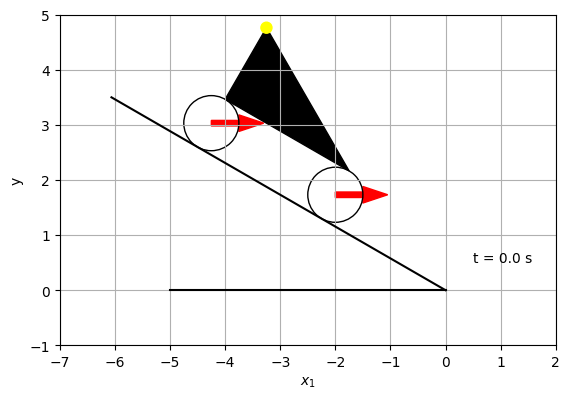

In [57]:
from typing import List, Tuple

l = 3  # length between wheels
r = 0.5  # radius of wheels
h0 = 3  # initial height of the cart


def rotz(theta):
    return np.array(
        [
            [np.cos(theta), -np.sin(theta), 0],
            [np.sin(theta), np.cos(theta), 0],
            [0, 0, 1],
        ]
    )


def wheel1(x, xi) -> Tuple[float, float]:
    # front wheel of the cart
    wshx = r * np.cos(a)
    wshy = r * np.sin(a)

    cp = cart(x, xi)

    shift = np.array([0, r, 0])

    return cp[1] - np.dot(shift, rotz(a))[:2]


def wheel2(x, xi) -> Tuple[float, float]:
    # back wheel of the cart
    wshx = r * np.cos(a)
    wshy = r * np.sin(a)

    cp = cart(x, xi)

    shift = np.array([0, r, 0])

    return cp[0] - np.dot(shift, rotz(a))[:2]


def wheel_a(x, xi) -> float:
    return -x / r


def cart(x, xi) -> np.ndarray:
    # x position is start of cart
    wshx = 2 * r * np.cos(a)
    wshy = 2 * r * np.sin(a)

    x0 = -h0 / np.tan(a)

    pos = np.array(
        [
            [x0 + x, 0, 0],
            [x0 + x + l * np.cos(a), 0, 0],
            [x0 + x, l * np.sin(a), 0],
        ]
    )
    # shift pos by [wshx, wshy]
    pos = pos + np.array([0, 2 * r, 0])

    res = np.dot(pos, rotz(a))[:, :2]
    return res


def particle(x, xi) -> Tuple[float, float]:
    # starts from top of the cart

    top = np.array([*cart(x, xi)[2], 0])
    top = np.dot(top, rotz(-2 * a))
    top[0] += xi

    return np.dot(top, rotz(2 * a))[:2]


# create simulation for matplotlib

from matplotlib.animation import FuncAnimation
import matplotlib.patches as p


fig, ax = subplots()
ax.set_xlim(-7, 2)
ax.set_ylim(-1, 5)
ax.set_aspect("equal")
ax.grid(True)
ax.set_xlabel("$x_1$")
ax.set_ylabel('y')


# draw a triangle (0, 0), (-2, 0) with angle 30 degrees
ax.plot([-5, 0], [0, 0], color="black")
ax.plot(
    [7 * np.cos(np.pi - np.pi / 6), 0],
    [7 * np.sin(np.pi - np.pi / 6), 0],
    color="black",
)

wheel1p = p.Circle(wheel1(x[0], xi[0]), r, color="black", fill=False)
wheel1a = ax.arrow(*wheel1(x[0], xi[0]), 0, 0, width=0.1, color="red")
wheel2p = p.Circle(wheel2(x[0], xi[0]), r, color="black", fill=False)
wheel2a = ax.arrow(*wheel2(x[0], xi[0]), 0, 0, width=0.1, color="red")
cartp = p.Polygon(cart(x[0], xi[0]), color="black")
particlep = p.Circle(particle(x[0], xi[0]), 0.1, color="yellow")
time = ax.text(0.5, 0.5, "t = 0.0 s")

ax.add_patch(cartp)
ax.add_patch(wheel1p)
ax.add_patch(wheel2p)
ax.add_patch(particlep)


def animate(i):
    time.set_text(f"t = {t[i]:.1f} s")
    cartp.set_xy(cart(x1[i], xi1[i]))
    wheel1p.center = wheel1(x1[i], xi1[i])
    wheel2p.center = wheel2(x1[i], xi1[i])
    wheel1a.set_data(
        x=wheel1(x1[i], xi1[i])[0],
        y=wheel1(x1[i], xi1[i])[1],
        dx=r * np.cos(wheel_a(x1[i], xi1[i])),
        dy=r * np.sin(wheel_a(x1[i], xi1[i])),
    )
    wheel2a.set_data(
        x=wheel2(x1[i], xi1[i])[0],
        y=wheel2(x1[i], xi1[i])[1],
        dx=r * np.cos(wheel_a(x1[i], xi1[i])),
        dy=r * np.sin(wheel_a(x1[i], xi1[i])),
    )
    particlep.center = particle(x1[i], xi1[i])


anim = FuncAnimation(fig, animate, frames=len(t1), interval=1)

anim.save("res.gif")
